In [1]:
import pandas as pd
from epiweeks import Week
from datetime import datetime

# 1. Load the data (using the URL from GitHub)
url = "https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/main/target-data/target-hospital-admissions.csv"
df = pd.read_csv(url)

# 2. Convert the text 'date' column to actual Python Date objects
df['date'] = pd.to_datetime(df['date'])

# 3. Create a helper function to convert a Date -> Epiweek
def get_epiweek(date_obj: datetime) -> Week:
    # This creates a Week object from the date
    return Week.fromdate(date_obj)

# 4. Apply it to create a new column
df['epi_week'] = df['date'].apply(lambda x: get_epiweek(x)) # type: ignore

# Now we can see which Epi Week each data point belongs to
print(df[['date', 'epi_week']].head())

# Note: The weekly_rate column of the input csv file is the weekly hosital admissions per 1000 people

        date epi_week
0 2026-01-10   202601
1 2026-01-10   202601
2 2026-01-10   202601
3 2026-01-10   202601
4 2026-01-10   202601


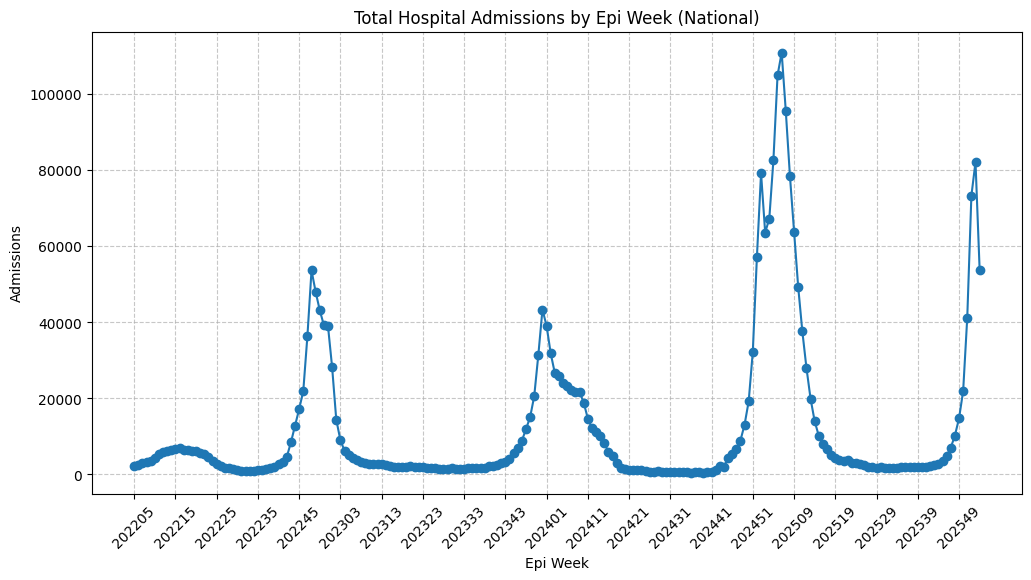

In [2]:
import matplotlib.pyplot as plt

# 1. Aggregate: Group by Epi Week and sum the 'value' (admissions)
# This collapses all state-level data into one national total per week
weekly_trend = df.groupby('epi_week')['value'].sum().reset_index()

# 2. Sort to ensure chronological order
weekly_trend = weekly_trend.sort_values('epi_week')

# 3. Create the Plot
plt.figure(figsize=(12, 6))
plt.plot(weekly_trend['epi_week'].astype(str), weekly_trend['value'], marker='o', linestyle='-')

x_values = weekly_trend['epi_week'].astype(str)
y_values = weekly_trend['value']
n = 10

# set_xticks needs two things: 
# 1. The positions (indices 0, 10, 20...)
# 2. The labels (the actual text at those positions)
plt.xticks(
    ticks=range(0, len(x_values), n), 
    labels=x_values.iloc[::n].tolist(),
    rotation=45
)

# 4. Styling
plt.title("Total Hospital Admissions by Epi Week (National)")
plt.xlabel("Epi Week")
plt.ylabel("Admissions")
plt.xticks(rotation=45) # Rotate labels for readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

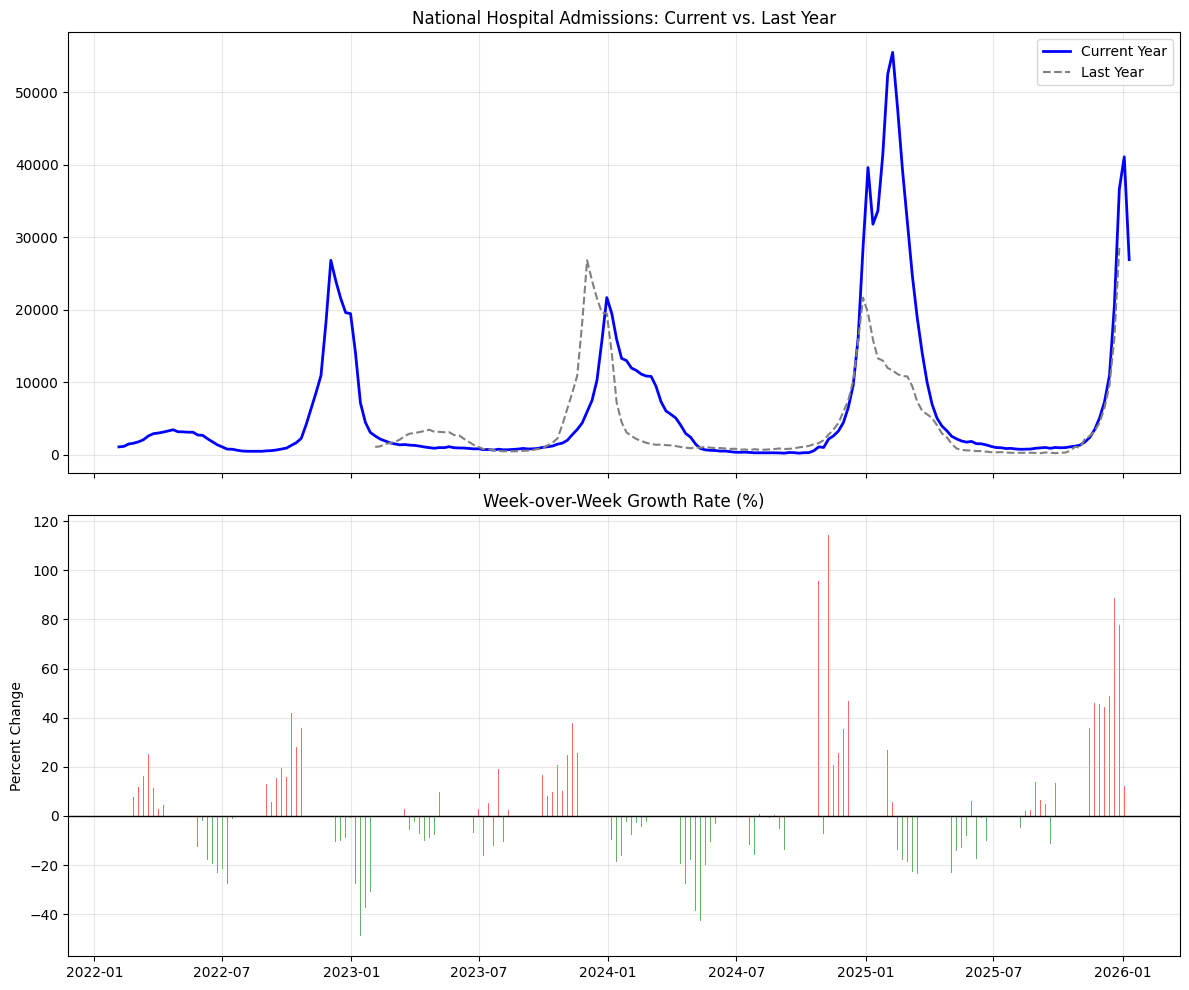

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from epiweeks import Week

# 1. Load Data
# (Using your local path)
path = '/Users/hangy/OneDrive/Data Science/01 UVA FluSight/FluSight-forecast-hub/target-data/target-hospital-admissions.csv'
df = pd.read_csv(path)
df['date'] = pd.to_datetime(df['date'])

# 2. Feature Engineering (The Corrected Part)
# We define a simple function to extract the integer safely
def get_epi_int(date_obj):
    w = Week.fromdate(date_obj)
    # Combine year and week into an integer like 202601
    return w.year * 100 + w.week

df['epi_week'] = df['date'].apply(get_epi_int)

# Now we can safely split them
df['year'] = df['epi_week'] // 100
df['week'] = df['epi_week'] % 100

# 3. Filter for National Data (US Only)
# We calculate metrics only on the US subset to avoid double-counting states
subset = df[df['location'] == 'US'].copy().sort_values('date')

# 4. Calculate Comparisons
# Metric A: Week-over-Week (Velocity)
subset['wow_pct_change'] = subset['value'].pct_change() * 100

# Metric B: Year-over-Year (Context)
# Create lookup for last year
last_year = subset[['year', 'week', 'value']].copy()
last_year['year'] += 1  # Shift to match current year
last_year = last_year.rename(columns={'value': 'prev_year_val'})

# Merge
subset = subset.merge(last_year, on=['year', 'week'], how='left')

# 5. Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Top Plot: Context
ax1.plot(subset['date'], subset['value'], label='Current Year', color='blue', linewidth=2)
ax1.plot(subset['date'], subset['prev_year_val'], label='Last Year', color='gray', linestyle='--')
ax1.set_title("National Hospital Admissions: Current vs. Last Year")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom Plot: Velocity
# Use .fillna(0) to handle the first row which has no previous week
colors = subset['wow_pct_change'].fillna(0).apply(lambda x: 'red' if x > 0 else 'green')
ax2.bar(subset['date'], subset['wow_pct_change'], color=colors, alpha=0.6)
ax2.axhline(0, color='black', linewidth=1)
ax2.set_title("Week-over-Week Growth Rate (%)")
ax2.set_ylabel("Percent Change")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()